In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('News.csv',index_col=0)
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [3]:
data.shape

(44919, 5)

In [4]:
data = data.drop(["title", "subject","date"], axis = 1)

In [5]:
data.isnull().sum()

,0
text,0
class,0


In [6]:
# Shuffling
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

<Axes: xlabel='class', ylabel='count'>

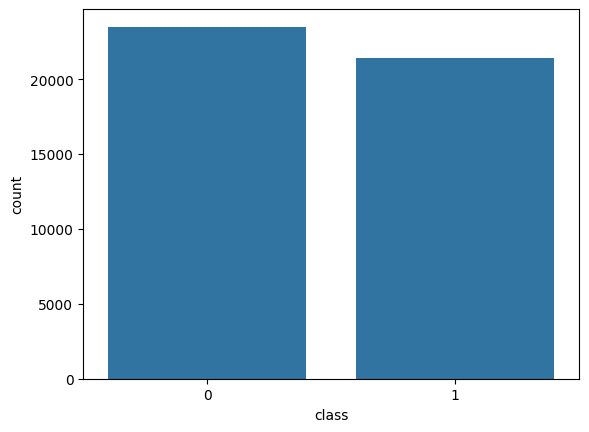

In [7]:
sns.countplot(data=data,
			x='class',
			order=data['class'].value_counts().index)

In [8]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def preprocess_text(text_data):
	preprocessed_text = []

	for sentence in tqdm(text_data):
		sentence = re.sub(r'[^\w\s]', '', sentence)
		preprocessed_text.append(' '.join(token.lower()
								for token in str(sentence).split()
								if token not in stopwords.words('english')))

	return preprocessed_text

In [10]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

100%|██████████| 44919/44919 [29:34<00:00, 25.31it/s]


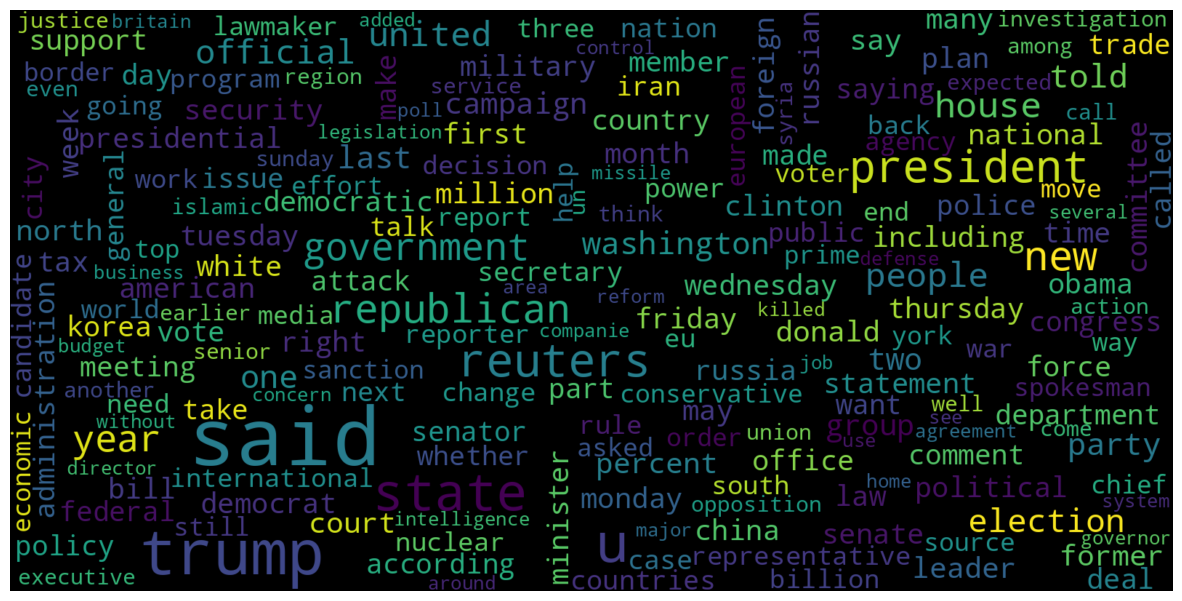

In [11]:
# Real
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

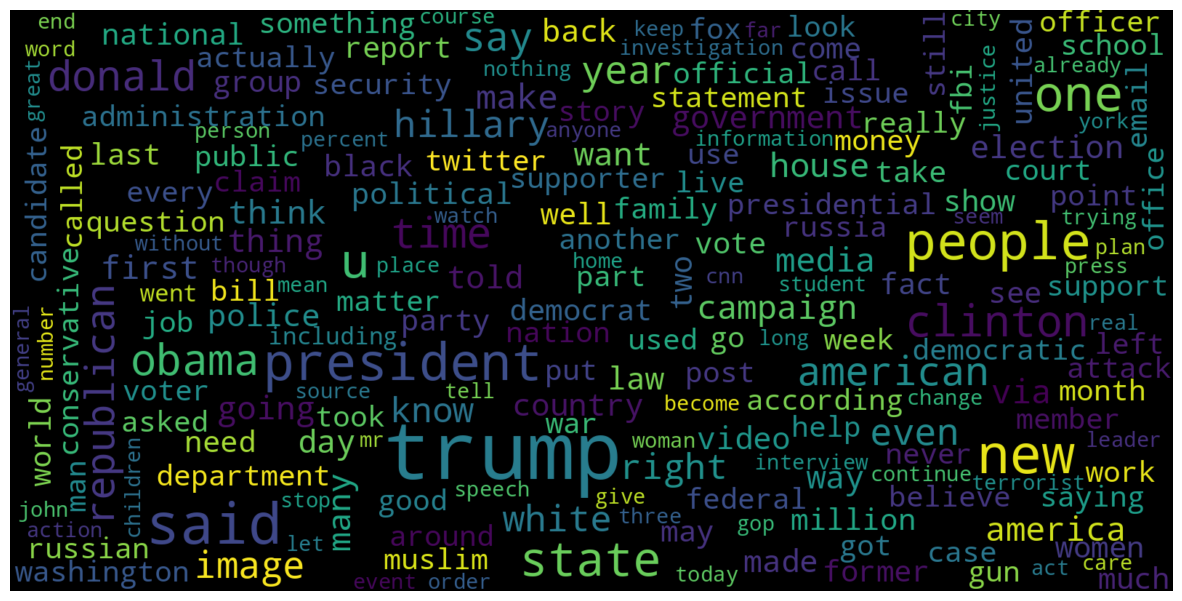

In [12]:
# Fake
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

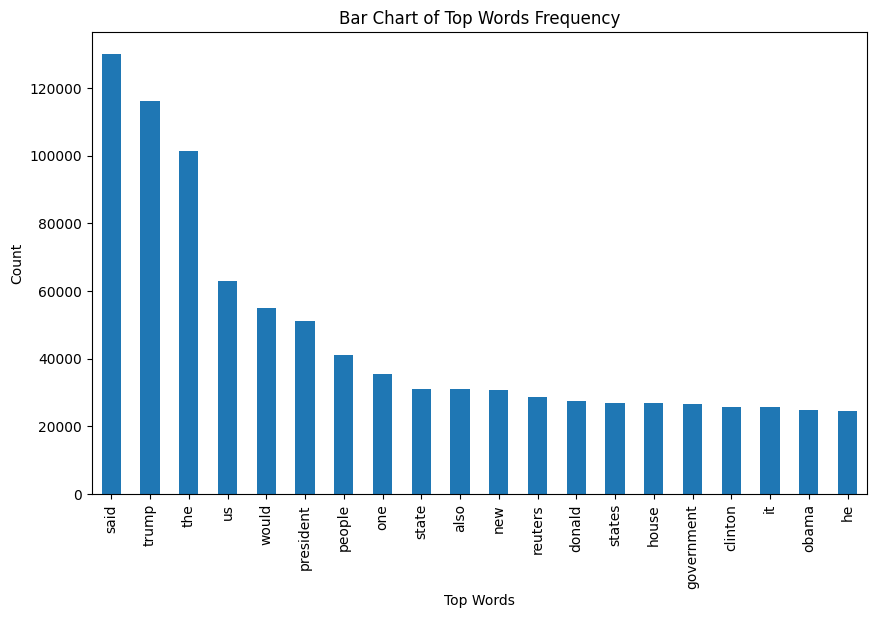

In [13]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
	vec = CountVectorizer().fit(corpus)
	bag_of_words = vec.transform(corpus)
	sum_words = bag_of_words.sum(axis=0)
	words_freq = [(word, sum_words[0, idx])
				for word, idx in vec.vocabulary_.items()]
	words_freq = sorted(words_freq, key=lambda x: x[1],
						reverse=True)
	return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
	kind='bar',
	figsize=(10, 6),
	xlabel="Top Words",
	ylabel="Count",
	title="Bar Chart of Top Words Frequency"
)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


x_train, x_test, y_train, y_test = train_test_split(data['text'],
													data['class'],
													test_size=0.40)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)


Evaluating Model: Logistic Regression
Training Accuracy: 0.9933
Training Precision: 0.9925
Training Recall: 0.9935
Training F1 Score: 0.9930



Testing Accuracy: 0.9867
Testing Precision: 0.9834
Testing Recall: 0.9888
Testing F1 Score: 0.9861


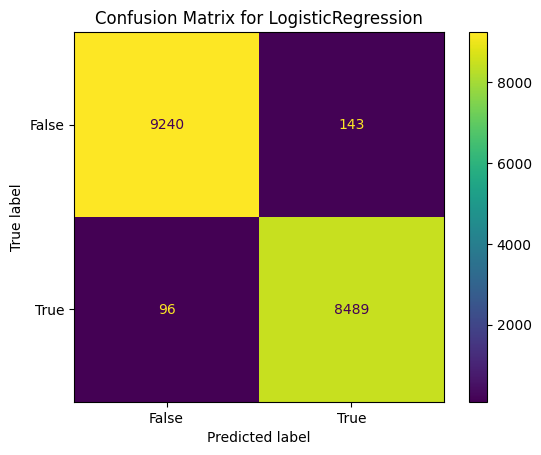


Evaluating Model: Decision Tree
Training Accuracy: 1.0000
Training Precision: 1.0000
Training Recall: 0.9999
Training F1 Score: 1.0000



Testing Accuracy: 0.9957
Testing Precision: 0.9957
Testing Recall: 0.9953
Testing F1 Score: 0.9955


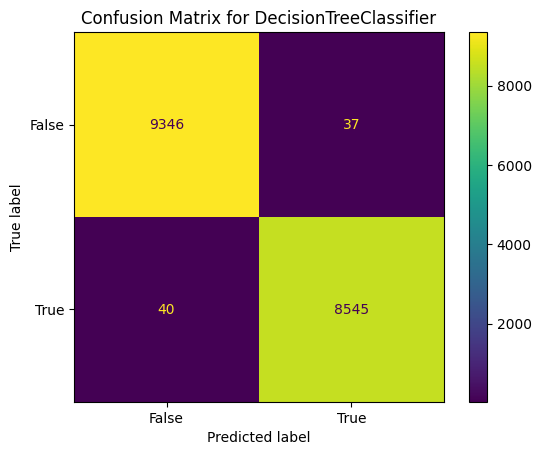

In [16]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    # Evaluation metrics for train data
    print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Training Precision: {precision_score(y_train, y_pred_train):.4f}")
    print(f"Training Recall: {recall_score(y_train, y_pred_train):.4f}")
    print(f"Training F1 Score: {f1_score(y_train, y_pred_train):.4f}")

    print("\n\n")
    # Evaluation metrics for test data
    print(f"Testing Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"Testing Precision: {precision_score(y_test, y_pred_test):.4f}")
    print(f"Testing Recall: {recall_score(y_test, y_pred_test):.4f}")
    print(f"Testing F1 Score: {f1_score(y_test, y_pred_test):.4f}")



    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
    disp.plot()
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

# Model Definitions and Evaluation
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
}

for model_name, model in models.items():
    print(f"\nEvaluating Model: {model_name}")
    evaluate_model(model, x_train, y_train, x_test, y_test)